## Initialize the environment

In [1]:
%load_ext autoreload
%autoreload 2

import jax
from env import NavigationEnvParams, NavigationEnv
from rooms import RoomParams, generate_rooms

ROOM_SEED = 42

# Generate rooms
room_key = jax.random.PRNGKey(ROOM_SEED)
room_params = RoomParams(size=8.0, grid_size=16)
obstacles, free_positions = generate_rooms(room_key, room_params)

# Initialize environment parameters with generated rooms
env_params = NavigationEnvParams(
    rooms=room_params,
    obstacles=obstacles,
    free_positions=free_positions,
    lidar_fov=90
)


## Initialize the agent - the RL algorithm

This is the only part of the notebook that is specific to the RL algorithm (the only part in which files `ppo.ipynb`, `sac.ipynb`, and `td3.ipynb`)


- Each RL algorithm from `rejax` has it's own hyperparameters passed through the `config` dictionary. The shape varies depending on the algorithm. 
- Skipped hyperparameters are set to default values.
- To see full list of hyperparameters in the `config` dictionary uncomment the last line of the cell below.

In [2]:
from rejax import PPO

# Initialize the training algorithm parameters
config = {
    # Pass our environment to the agent
    "env": NavigationEnv(),
    "env_params": env_params,
    "total_timesteps": 1_000_000,
    "normalize_observations": True, 
    "num_steps": 128, 
    "num_minibatches": 128, 
    "num_envs": 512, 
    "agent_kwargs": {
        "hidden_layer_sizes": (128, 128),
    },
}

# Create the training algorithm agent from `rejax` library
agent = PPO.create(**config)

# Uncomment to see the full config of the RL algorithm
# print(agent.config)

## Train the agent

In [3]:
import jax
import time

# Set the seed for reproducibility
TRAIN_SEED = 43

# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(agent.train)

print("Starting to train")

# Train!
start = time.time()
train_state, train_evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = agent.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")


Starting to train
Finished training in 107.353 seconds (9315.05 steps/second).


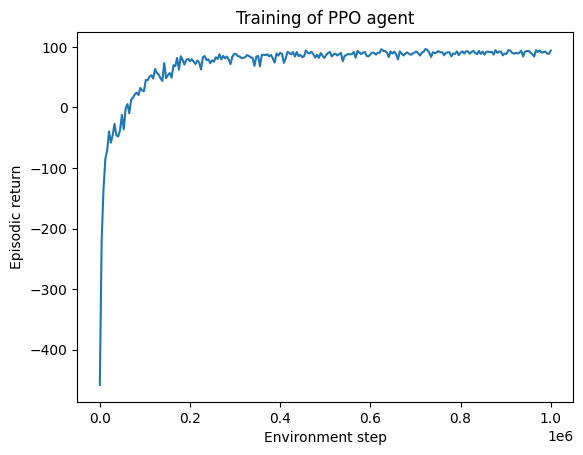

In [4]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = train_evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, agent.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training of {agent.__class__.__name__} agent")
plt.show()

## Evaluatation

Let's evaluate the agent on the test set of rooms and visualize the results.

In [5]:
from eval import evaluate_model

# Set the seed for reproducibility
TEST_SEED = 77

evaluation = evaluate_model(
    agent=agent, 
    train_state=train_state, 
    seed=TEST_SEED, 
    render=True,
    n_eval_episodes=10,
)


Evaluation finished, mean return: 95.38101959228516
Recorded 2000 frames


## Visualization

Use functionality from `env_vis.py` to visualize the agent's performance in the test set of rooms.

In [ ]:
from env_vis import save_gif
from pathlib import Path
from IPython.display import Image as IPImage, display

if evaluation.rendered_frames is not None:
    path = Path(f"temp/{agent.__class__.__name__}_policy.gif")
    save_gif(evaluation.rendered_frames, path)

    display(IPImage(filename=path))